Hello World!

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import attila_utils
from bsmcalls import SNPnexus
from bsmcalls import operations
from bsmcalls import resources
from bsmcalls import individuals
from bsmcalls import stats as bsmstats
import statsmodels.api as sm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import graphics as smg
from statsmodels.graphics import regressionplots
from statsmodels.graphics import dotplots
import patsy
import scipy.stats as stats
import indiv_counts_modeling as icm
%matplotlib inline

In [2]:
data = SNPnexus.load_data('/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p')
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = operations.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')

In [3]:
# near_gens
querydict = {'near_gens_Annotation': ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             'ensembl_Predicted Function': ['coding'],
             'sift_Prediction': ['Deleterious', 'Deleterious - Low Confidence'],
             'polyphen_Prediction': ['Probably Damaging', 'Possibly Damaging'],
             'tfbs_TFBS Name': None,
             'phast_Score': None,
             'gerp_Element RS Score': None,
             'cpg_CpG Island': None,
             'near_gens_Overlapped Gene': {'SCZ GWAS genes': gwasgenes},
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False)
summary = operations.summarize_query_results(results, data, chisq=False, margin=False)
summary#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Dx                                                       Control  SCZ  ASD
Feature                    Query                                          
near_gens_Annotation       coding nonsyn                      23   43   23
                           coding syn                         16   20   15
                           missense                            0    0    0
                           stop-gain                           1    0    0
                           intronic (splice_site)              0    1    0
ensembl_Predicted Function coding                             39   64   40
sift_Prediction            Deleterious                         8    9    6
                           Deleterious - Low Confidence        1    1    2
polyphen_Prediction        Probably Damaging                   3    5    2
                           Possibly Damaging                   2    2    0
tfbs_TFBS Name             any                                48   78   50
phast_Score                any                               102  174  141
gerp_Element RS Score      any                               140  262  208
cpg_CpG Island             any                                26   47   19
near_gens_Overlapped Gene  SCZ GWAS genes                     20   66   42

In [4]:
d = {'ncalls': data.groupby('Dx').size(), 'nsamples': individuals.get_nsamples(results)}
dfd = {k: operations.chisquare_summary(summary, expected_odds, append=False) for k, expected_odds in d.items()}
dfl = [pd.DataFrame(df.to_numpy(), columns=pd.MultiIndex.from_product([[k], df.columns]), index=df.index) for k, df in dfd.items()]
df = pd.concat(dfl, axis=1)
df

/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


ncalls            \
                                                        chisq stat   chisq p   
Feature                    Query                                               
near_gens_Annotation       coding nonsyn                  4.480340  0.106440   
                           coding syn                     1.177849  0.554924   
                           missense                            NaN       NaN   
                           stop-gain                      2.887477  0.236044   
                           intronic (splice_site)         1.582797  0.453210   
ensembl_Predicted Function coding                         3.794387  0.149989   
sift_Prediction            Deleterious                    1.315056  0.518131   
                           Deleterious - Low Confidence   0.429823  0.806613   
polyphen_Prediction        Probably Damaging              1.080625  0.582566   
                           Possibly Damaging              2.470275  0.290795   
tfbs_TFBS Name             any                            4.120011  0.127453   
phast_Score                any                            1.591145  0.451323   
gerp_Element RS Score      any                            5.012216  0.081585   
cpg_CpG Island             any                            9.614759  0.008169   
near_gens_Overlapped Gene  SCZ GWAS genes                10.800565  0.004515   

                                                          nsamples            
                                                        chisq stat   chisq p  
Feature                    Query                                              
near_gens_Annotation       coding nonsyn                  4.765326  0.092304  
                           coding syn                     1.371564  0.503696  
                           missense                            NaN       NaN  
                           stop-gain                      2.950000  0.228779  
                           intronic (splice_site)         1.590164  0.451544  
ensembl_Predicted Function coding                         4.219225  0.121285  
sift_Prediction            Deleterious                    1.451859  0.483875  
                           Deleterious - Low Confidence   0.406971  0.815882  
polyphen_Prediction        Probably Damaging              1.139182  0.565757  
                           Possibly Damaging              2.540164  0.280809  
tfbs_TFBS Name             any                            4.620352  0.099244  
phast_Score                any                            1.763406  0.414077  
gerp_Element RS Score      any                            4.990139  0.082491  
cpg_CpG Island             any                           10.092813  0.006432  
near_gens_Overlapped Gene  SCZ GWAS genes                10.690924  0.004770

['named-figure/ncall_nindiv_count-Dx.png',
 'named-figure/ncall_nindiv_count-Dx.pdf']

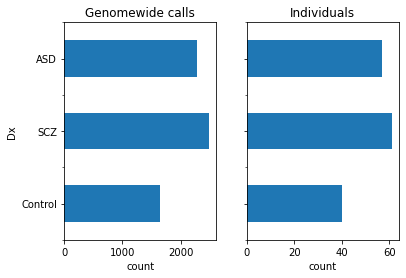

In [5]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, sharey=True)
d['ncalls'].plot(kind='barh', ax=ax[0])
pd.Series(d['nsamples']).plot(kind='barh', ax=ax[1])
ax[0].set_title('Genomewide calls')
ax[1].set_title('Individuals')
ax[0].set_xlabel('count')
ax[1].set_xlabel('count')
attila_utils.savefig(fig, 'ncall_nindiv_count-Dx')

## Limitations of the $\chi^2$ test

* univariate: it doesn't allow easy analysis of joint effects of multiple features
* counts of calls are the only possible variable to model

### Example: calls weighted by allele frequency

This piece of analysis shows that weighting each call with its allele frequency decreases significance of the $\chi^2$ test since the $\mathrm{AF} < 1$ (moreover $\mathrm{AF} \ll 1$ for most calls).

In [6]:
wncalls = data.groupby('Dx')['AF'].sum()
wresults = results.drop(('Dx', ), axis=1).astype('int16').apply(lambda x: x * data['AF'], axis=0)
operations.chisquare_summary(summary, expected_odds=wncalls, append=False)

/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


chisq stat   chisq p
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                   1.152128  0.562107
                           coding syn                      0.491868  0.781974
                           missense                             NaN       NaN
                           stop-gain                       2.675849  0.262390
                           intronic (splice_site)          1.330329  0.514189
ensembl_Predicted Function coding                          0.288166  0.865816
sift_Prediction            Deleterious                     0.673078  0.714238
                           Deleterious - Low Confidence    0.847928  0.654447
polyphen_Prediction        Probably Damaging               0.472640  0.789528
                           Possibly Damaging               2.006178  0.366745
tfbs_TFBS Name             any                             0.209300  0.900640
phast_Score                any                             3.446117  0.178519
gerp_Element RS Score      any                             7.684747  0.021443
cpg_CpG Island             any                             4.093641  0.129145
near_gens_Overlapped Gene  SCZ GWAS genes                  8.908390  0.011630

## DataFrame for regression: `fitdata`

In [7]:
selcols = ['DP', 'BaseQRankSum', 'AF']
covariates = data[selcols].groupby('Individual ID').mean()
selcols_indiv = ['Dx', 'ageOfDeath', 'Dataset']
covariates[selcols_indiv] = data[selcols_indiv].groupby('Individual ID').first()
covariates['ncalls'] = data.groupby('Individual ID').size()
covariates = pd.concat([covariates, covariates['ncalls'].apply(np.log10).rename('log10_ncalls')], axis=1)
covariates

,DP,BaseQRankSum,AF,Dx,ageOfDeath,Dataset,ncalls,log10_ncalls
Individual ID,,,,,,,,
AN02255,186.714286,0.919714,0.063810,ASD,20.0,Walsh,21,1.322219
AN05983,215.102703,0.531795,0.027784,ASD,24.0,Walsh,185,2.267172
AN06365,208.592593,-0.069296,0.058519,ASD,10.0,Walsh,27,1.431364
AN09412,265.500000,1.695567,0.076000,ASD,29.0,Walsh,30,1.477121
AN12434,241.234043,0.870851,0.060851,ASD,18.0,Walsh,47,1.672098
...,...,...,...,...,...,...,...,...
UMB5878,269.066667,0.222433,0.055333,ASD,27.0,Walsh,30,1.477121
UMB5939,191.833333,0.798708,0.085833,ASD,21.0,Walsh,24,1.380211
UMB797,200.380952,1.083071,0.031429,ASD,9.0,Walsh,42,1.623249


In [8]:
Dxs = pd.Categorical(results[('Dx', )].groupby('Individual ID').first(), categories=results[('Dx', )].cat.categories)
responses = results.drop(('Dx',), axis=1).groupby('Individual ID').sum()
prettynames = ['coding_nonsyn', 'coding_syn', 'missense', 'stop_gain', 'splice_site', 'coding', 'deleterious', 'deleterious_low_confidence', 'probably_damaging', 'possibly_damaging', 'tfbs', 'phast', 'gerp', 'cpg_island', 'scz_gwas_genes']
responses.columns = prettynames
responses.info()

<class 'pandas.core.frame.DataFrame'>
Index: 158 entries, AN02255 to UMB914
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   coding_nonsyn               158 non-null    int16
 1   coding_syn                  158 non-null    int16
 2   missense                    158 non-null    int16
 3   stop_gain                   158 non-null    int16
 4   splice_site                 158 non-null    int16
 5   coding                      158 non-null    int16
 6   deleterious                 158 non-null    int16
 7   deleterious_low_confidence  158 non-null    int16
 8   probably_damaging           158 non-null    int16
 9   possibly_damaging           158 non-null    int16
 10  tfbs                        158 non-null    int64
 11  phast                       158 non-null    int64
 12  gerp                        158 non-null    int64
 13  cpg_island                  158 non-null    int64
 14  scz_gw

/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/attila/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [9]:
responses_prop = responses.apply(lambda x: x / covariates['ncalls'], axis=0).rename(lambda x: 'prop_' + x, axis=1)

In [10]:
fitdata = pd.concat([responses, covariates], axis=1)

df = pd.DataFrame(data.groupby('Individual ID').size(), columns=['ncalls'])
df['ncalls_scz_gwas_genes'] = results[('near_gens_Overlapped Gene', 'SCZ GWAS genes')].groupby('Individual ID').sum()
df['fcalls_scz_gwas_genes'] = df['ncalls_scz_gwas_genes'] / df['ncalls']
selindivcols = ['Dx', 'ageOfDeath']
df[selindivcols] = data[selindivcols].groupby('Individual ID').first()
selcols = ['DP', 'BaseQRankSum', 'AF']
df[selcols] = data[selcols].groupby('Individual ID').mean()
scz_gwas_genes = df
scz_gwas_genes

### Pairwise joint distributions

* No two variables show extremely tight dependence which implies limited collinearity in a normal or generalized linear model.
* The fraction of calls `fcalls_scz_gwas_genes` has very high variance when the total number of calls for an individual is low. This is undesirable.

/home/attila/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


['named-figure/symmetric-scatter-matrix.png',
 'named-figure/symmetric-scatter-matrix.pdf']

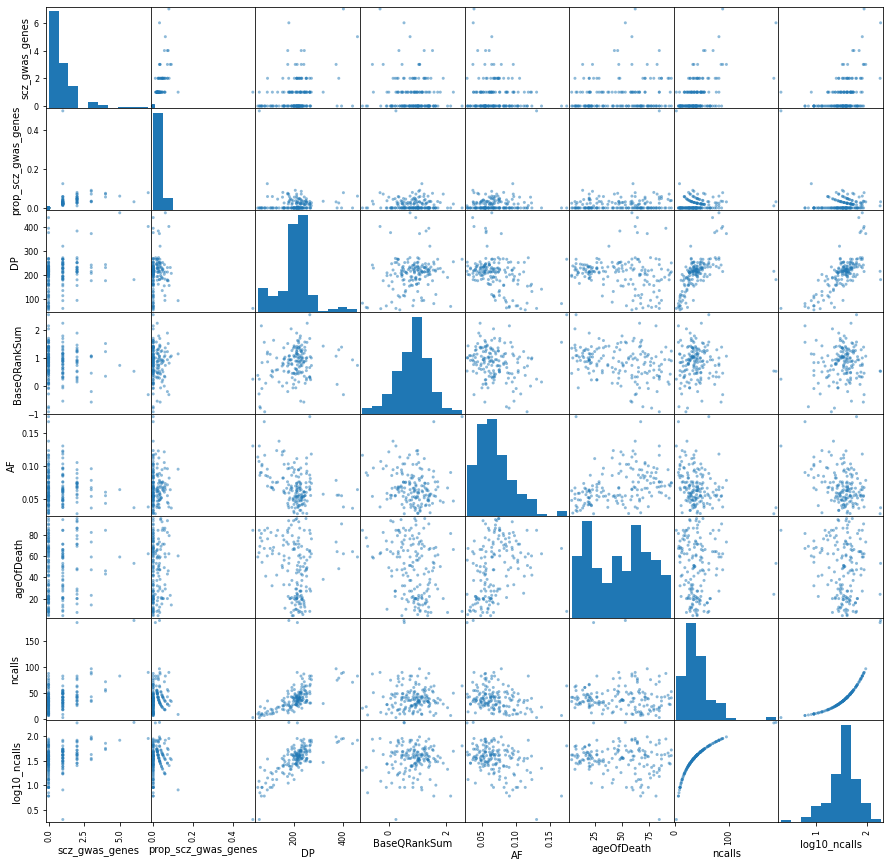

In [11]:
df = pd.concat([responses['scz_gwas_genes'], responses_prop['prop_scz_gwas_genes'], covariates], axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
ax = pd.plotting.scatter_matrix(df, figsize=(15, 15), ax=ax)
attila_utils.savefig(fig, 'symmetric-scatter-matrix')

['named-figure/ncalls-scz_gwas_gene-ncalls.png',
 'named-figure/ncalls-scz_gwas_gene-ncalls.pdf']

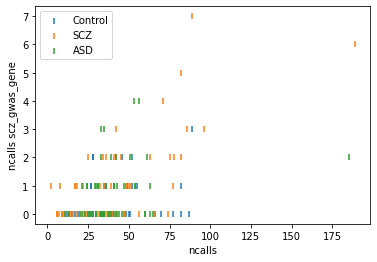

In [12]:
fig, ax = plt.subplots()
for Dx in ['Control', 'SCZ', 'ASD']:
    ax.scatter(x='ncalls', y='scz_gwas_genes', data=fitdata.loc[fitdata['Dx'] == Dx], marker='|', label=Dx)
ax.legend()
ax.set_xlabel('ncalls')
ax.set_ylabel('ncalls scz_gwas_gene')
attila_utils.savefig(fig, 'ncalls-scz_gwas_gene-ncalls')

## Multiple functional categories
### Response: ncalls in functional categ

Here the response (endogenous or dependent variable) is the number of calls per individual in some functinal category, and is plotted on the y axis.

The genome-wide number of calls per individual (`ncalls` or `log10_ncalls`) is regarded as an explanatory variable, and is plotted on the x axis.

['named-figure/ncalls-func-categ-predictors.png',
 'named-figure/ncalls-func-categ-predictors.pdf']

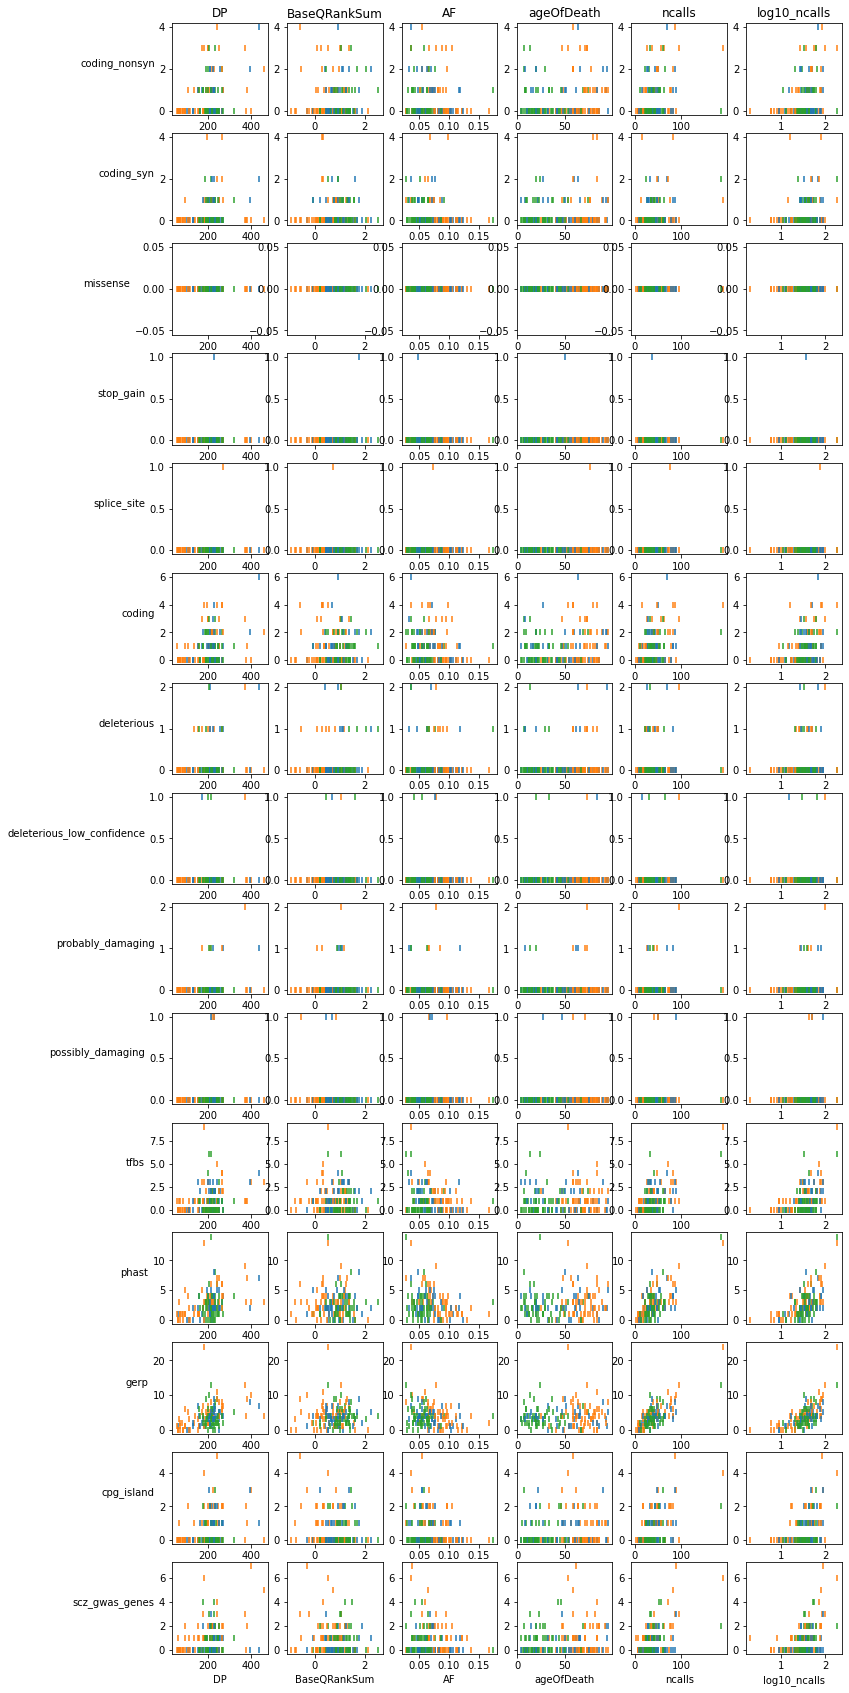

In [13]:
Dxs = fitdata['Dx'].copy()
Dxcol = Dxs.cat.rename_categories(['C0', 'C1', 'C2'])
fig, ax = icm.big_plot_matrix(responses, covariates, Dxcol)
attila_utils.savefig(fig, 'ncalls-func-categ-predictors')

### More transformations

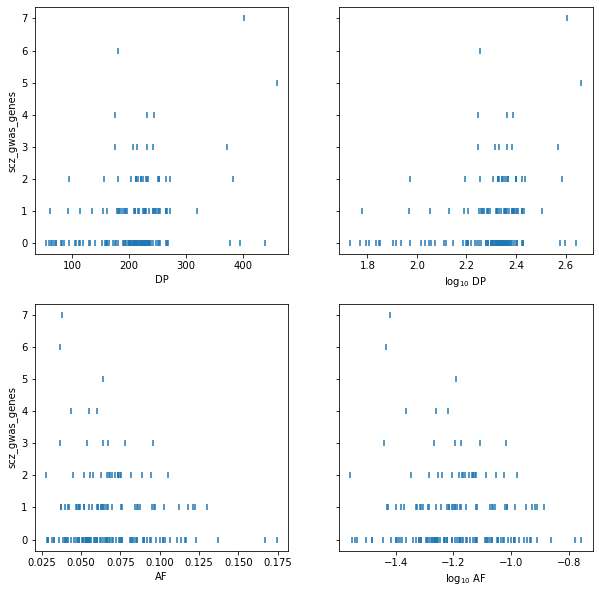

In [14]:
%matplotlib inline
features = ['DP', 'AF']
fig, ax = plt.subplots(len(features), 2, figsize=(10, 10), sharey=True)
for i, feature in zip(range(len(features)), features):
    ax[i, 0].scatter(y=responses['scz_gwas_genes'], x=covariates[feature], marker='|')
    ax[i, 0].set_ylabel('scz_gwas_genes')
    ax[i, 0].set_xlabel(feature)
    ax[i, 1].scatter(y=responses['scz_gwas_genes'], x=np.log10(covariates[feature]), marker='|')
    ax[i, 1].set_xlabel('$\log_{10}$ ' + feature)

### Response: proportion of calls in func categ

In this case we take the proportion, for each individual, of the following two counts:
1. the number calls in some functional category and
1. the genome wide number of calls

The advantage of this definition of response over the previous one is that now we directly condition the first variable on the second for each individual.

['named-figure/prop_calls-func-categ-predictors.png',
 'named-figure/prop_calls-func-categ-predictors.pdf']

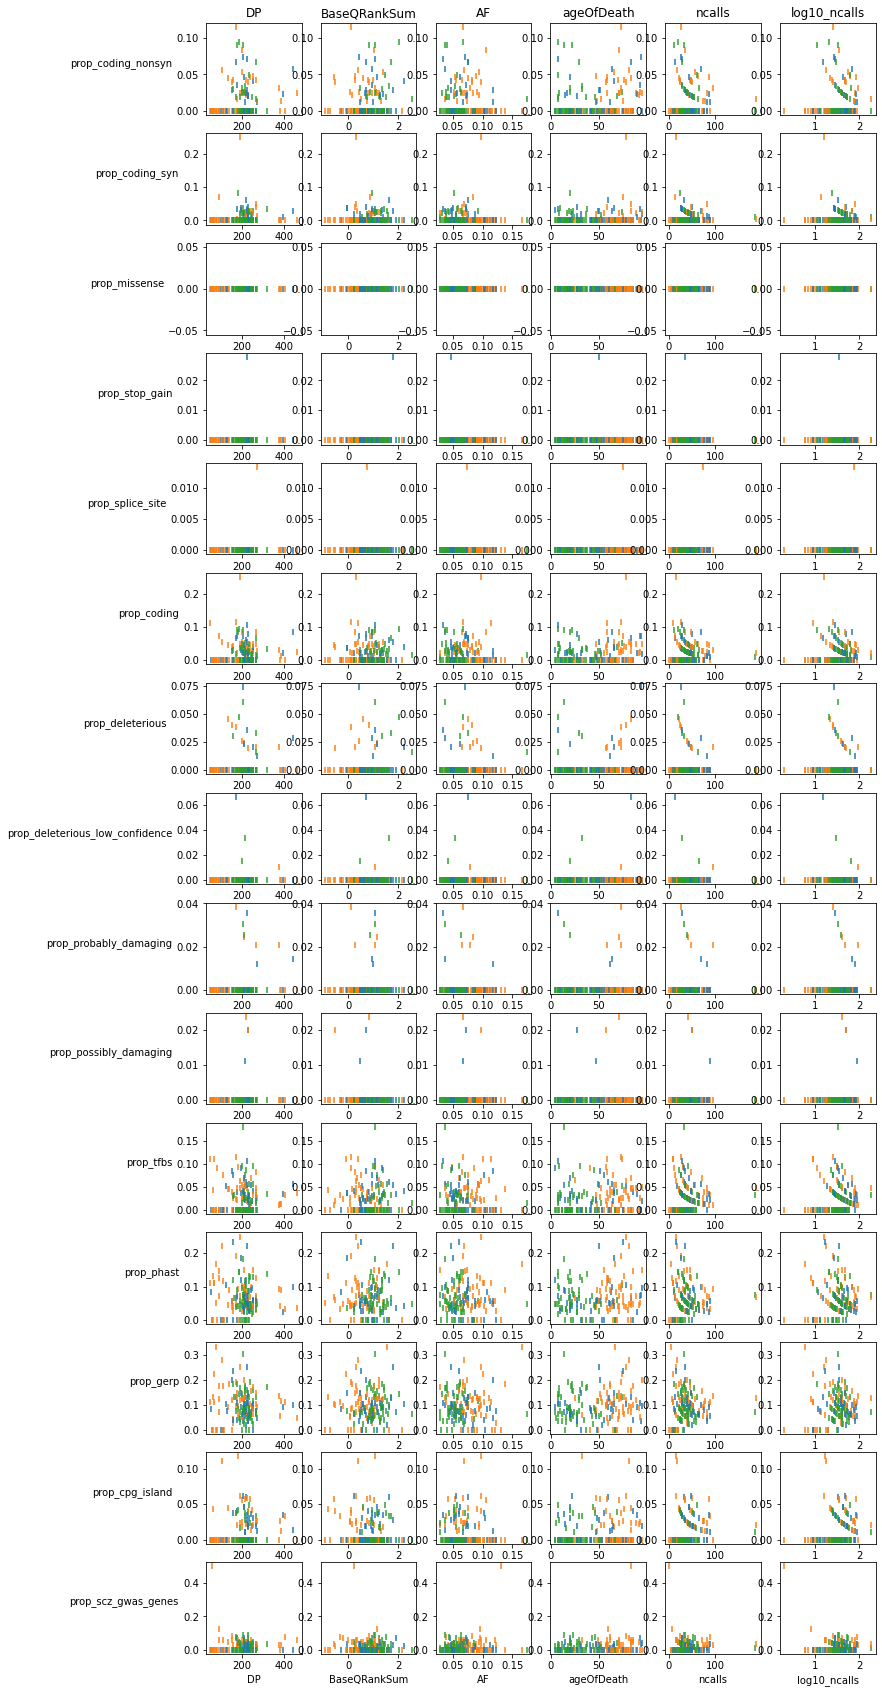

In [15]:
fig, ax = icm.big_plot_matrix(responses_prop, covariates, Dxcol)
attila_utils.savefig(fig, 'prop_calls-func-categ-predictors')

## Training data for fitting models

First simplify column names and create data matrix

In [16]:
fitdata = pd.concat([responses, covariates], axis=1)
fitdata['Dx'] = Dxs
endog = responses
exog0 = fitdata.drop(prettynames + ['ncalls'], axis=1)
exog1 = fitdata.drop(prettynames + ['log10_ncalls'], axis=1)

In [17]:
def endog_binomial(feature, fitdata=fitdata, proportion=False):
    success = fitdata[feature]
    if proportion:
        prop = success / fitdata['ncalls']
        return(prop)
    failure = fitdata['ncalls'] - success
    complement = 'NOT_' + feature
    df = pd.DataFrame({feature: success, complement: failure})
    return(df)

## Log linear (Poisson) models

These models are fitted on the count type response: the number of calls within a functional category.  The genome wide number of calls `ncalls` enters the regression model as a covariate

In [18]:
formula = 'scz_gwas_genes ~ Dx'
y0, X0 = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
pois0 = sm.GLM(endog=y0, exog=X0, family=sm.families.Poisson()).fit()

In [19]:
formula = 'scz_gwas_genes ~ Dx + log10_ncalls'
y1, X1 = patsy.dmatrices(formula, data=fitdata, return_type='dataframe')
pois1 = sm.GLM(endog=y1, exog=X1, family=sm.families.Poisson()).fit()

The following plot shows the fit of the simplest log linear model `pois0` (horizontal lines) and the slightly more complex `pois1` (exponential lines).

['named-figure/scz_gwas_genes-log10_ncalls-poisson-fit.png',
 'named-figure/scz_gwas_genes-log10_ncalls-poisson-fit.pdf']

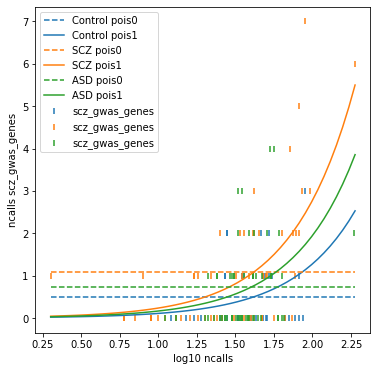

In [20]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 6))
left = fitdata['log10_ncalls'].min()
right = fitdata['log10_ncalls'].max()
log10_ncalls_test = np.linspace(left, right)
Dxd = {'Control': (0, 0), 'SCZ': (1, 0), 'ASD': (0, 1)}
for color, Dx in zip(['C0', 'C1', 'C2'], fitdata['Dx'].cat.categories):
    y0_pred = pois0.predict([1, *Dxd[Dx]])
    ax.plot([left, right], [y0_pred] * 2, linestyle='dashed', label=Dx + ' pois0')
    X_test = pd.DataFrame(dict(zip(X1.columns, [1, *Dxd[Dx], log10_ncalls_test])))
    ax.scatter(x='log10_ncalls', y='scz_gwas_genes', data=fitdata.loc[fitdata['Dx'] == Dx], marker='|', color=color)
    ax.plot(log10_ncalls_test, pois1.predict(X_test), color=color, label=Dx + ' pois1')
ax.legend()
ax.set_xlabel('log10 ncalls')
ax.set_ylabel('ncalls scz_gwas_genes')
attila_utils.savefig(fig, 'scz_gwas_genes-log10_ncalls-poisson-fit')

In [21]:
y = endog_binomial('scz_gwas_genes', fitdata, proportion=True)
formula = 'Dx'
X0 = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
formula = 'Dx + ageOfDeath'
X1 = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
binom0 = sm.GLM(endog=y, exog=X0, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
binom1 = sm.GLM(endog=y, exog=X1, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()

['named-figure/scz_gwas_genes-ageOfDeath-binom-fit.png',
 'named-figure/scz_gwas_genes-ageOfDeath-binom-fit.pdf']

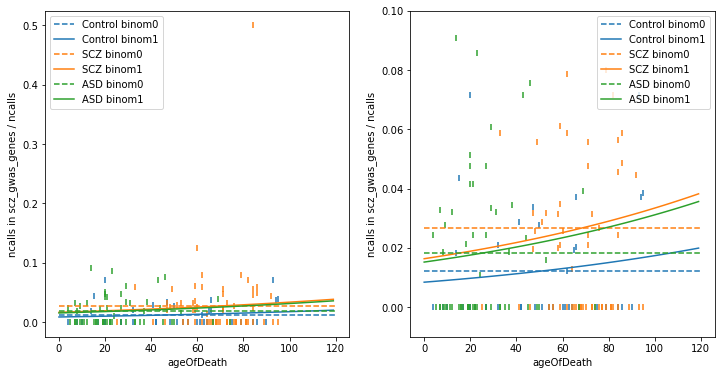

In [22]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
left = 0
right = 120
X_train = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
ageOfDeath_test = np.arange(0, 120)
proportion = icm.endog_binomial('scz_gwas_genes', fitdata, proportion=True)

for color, Dx in zip(['C0', 'C1', 'C2'], fitdata['Dx'].cat.categories):
    y0_pred = binom0.predict([1, *Dxd[Dx]])
    X_test = pd.DataFrame(dict(zip(X_train.columns, [1, *Dxd[Dx], ageOfDeath_test])))
    def myplot(ax):
        ax.scatter(y=proportion.loc[fitdata['Dx'] == Dx], x=fitdata.loc[fitdata['Dx'] == Dx, 'ageOfDeath'], marker='|', color=color)
        ax.plot([left, right], [y0_pred] * 2, linestyle='dashed', label=Dx + ' binom0')
        ax.plot(ageOfDeath_test, binom1.predict(X_test), color=color, label=Dx + ' binom1')
        ax.set_ylabel('ncalls in scz_gwas_genes / ncalls')
        ax.set_xlabel('ageOfDeath')
        ax.legend()
        return(ax)
    myplot(ax[0])
    myplot(ax[1])
    ax[1].set_ylim([-0.01, 0.10])

attila_utils.savefig(fig, 'scz_gwas_genes-ageOfDeath-binom-fit')

## Model selection

The partial residual plots reveal that the biggest outlier is actually an SCZ individual CMC_MSSM_201 with only one calls in SCZ GWAS genes and two calls genome wide.

In [23]:
exogs = ['log10_ncalls', 'Dx', 'ageOfDeath', 'BaseQRankSum', 'Dataset', 'AF', 'DP']
pois_modsel = icm.multifit(fitdata, 'scz_gwas_genes', exogs, sm.families.Poisson(), do_fwsel=True)
exogs.remove('log10_ncalls')
binom_modsel = icm.multifit(fitdata, 'scz_gwas_genes', exogs, sm.families.Binomial(), do_fwsel=True)

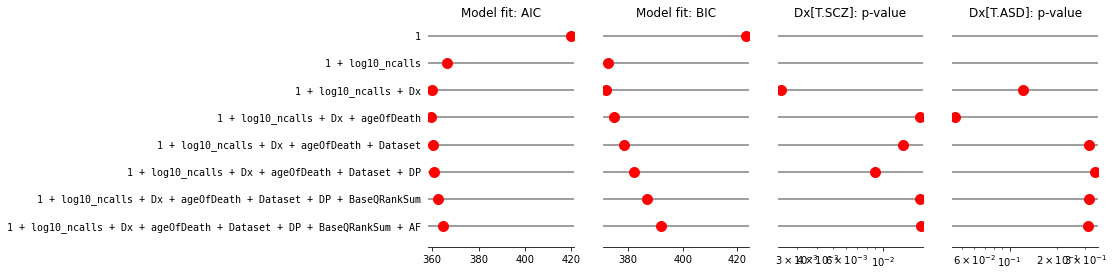

In [24]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(pois_modsel)

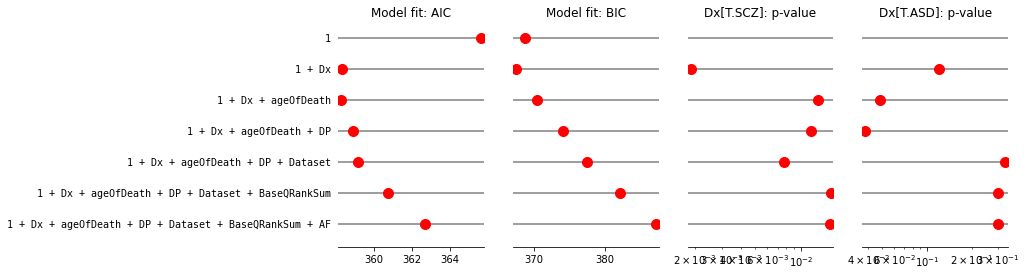

In [25]:
%matplotlib inline
fig, ax = icm.modsel_dotplot(binom_modsel)

## Checking model fit

['named-figure/scz_gwas_genes-poisson-partial-resid-plot.png',
 'named-figure/scz_gwas_genes-poisson-partial-resid-plot.pdf']

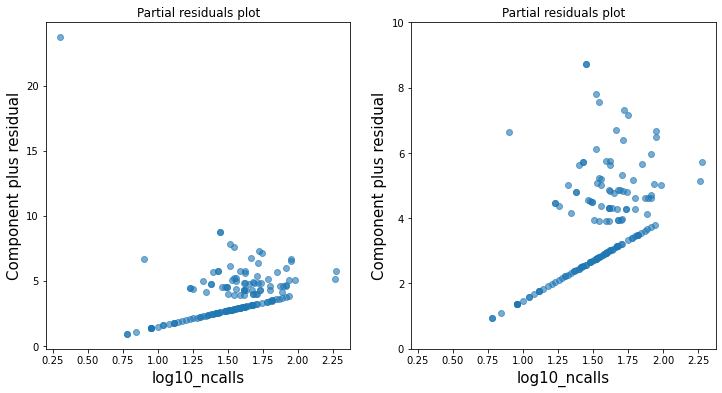

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
g = pois1.plot_partial_residuals('log10_ncalls', ax=ax[0])
g = pois1.plot_partial_residuals('log10_ncalls', ax=ax[1])
ax[1].set_ylim(0, 10)
attila_utils.savefig(fig, 'scz_gwas_genes-poisson-partial-resid-plot')

### Poisson model results

In [27]:
formula = '1 + log10_ncalls + Dx + ageOfDeath'
pois = pois_modsel[formula]
pois.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            359.5337 
Link Function:      log              BIC:            -596.0113
Dependent Variable: scz_gwas_genes   Log-Likelihood: -174.77  
Date:               2021-02-19 14:30 LL-Null:        -208.99  
No. Observations:   158              Deviance:       178.57   
Df Model:           4                Pearson chi2:   189.     
Df Residuals:       153              Scale:          1.0000   
Method:             IRLS                                      
--------------------------------------------------------------
                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------
Intercept      -5.1773   0.7128 -7.2629 0.0000 -6.5744 -3.7801
Dx[T.SCZ]       0.6419   0.2686  2.3900 0.0168  0.1155  1.1684
Dx[T.ASD]       0.6025   0.3012  2.0006 0.0454  0.0123  1.1928
log10_ncalls    2.5304   0.3495  7.2410 0.0000  1.8455  3.2153
ageOfDeath      0.0076   0.0051  1.4824 0.1382 -0.0024  0.0176
==============================================================

"""

In [28]:
formula = '1 + log10_ncalls + Dx'
X = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
endognames = ['coding_nonsyn', 'coding_syn', 'coding', 'deleterious', 'deleterious_low_confidence', 'probably_damaging', 'possibly_damaging', 'tfbs', 'phast', 'gerp', 'cpg_island', 'scz_gwas_genes']
ys = {endog: fitdata[endog] for endog in endognames}
poiss = {endog: sm.GLM(endog=ys[endog], exog=X, family=sm.families.Poisson()).fit() for endog in ys.keys()}

['named-figure/SCZ-significance-pois.png',
 'named-figure/SCZ-significance-pois.pdf']

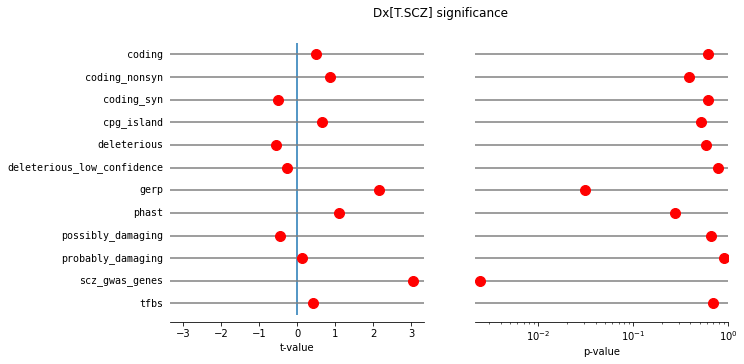

In [29]:
%matplotlib inline
fig, ax = icm.my_dotplot('Dx[T.SCZ]', poiss)
attila_utils.savefig(fig, 'SCZ-significance-pois')

['named-figure/ASD-significance-pois.png',
 'named-figure/ASD-significance-pois.pdf']

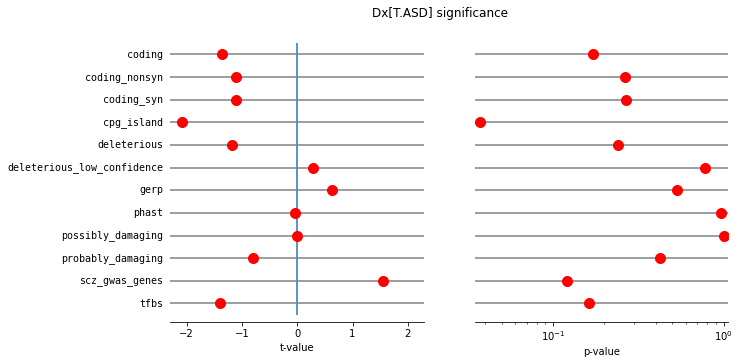

In [30]:
%matplotlib inline
fig, ax = icm.my_dotplot('Dx[T.ASD]', poiss)
attila_utils.savefig(fig, 'ASD-significance-pois')

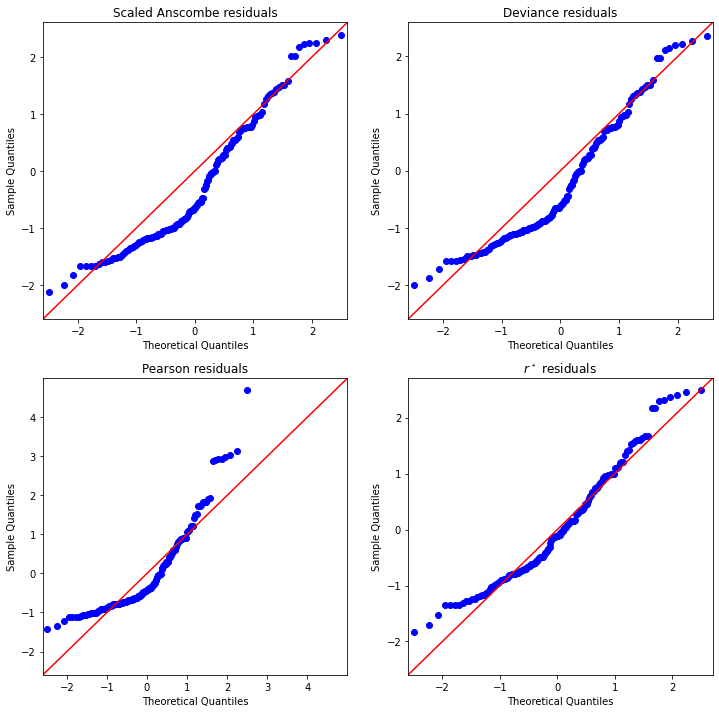

In [31]:
fig, ax = icm.QQ_four_residual_types(poiss['scz_gwas_genes'])

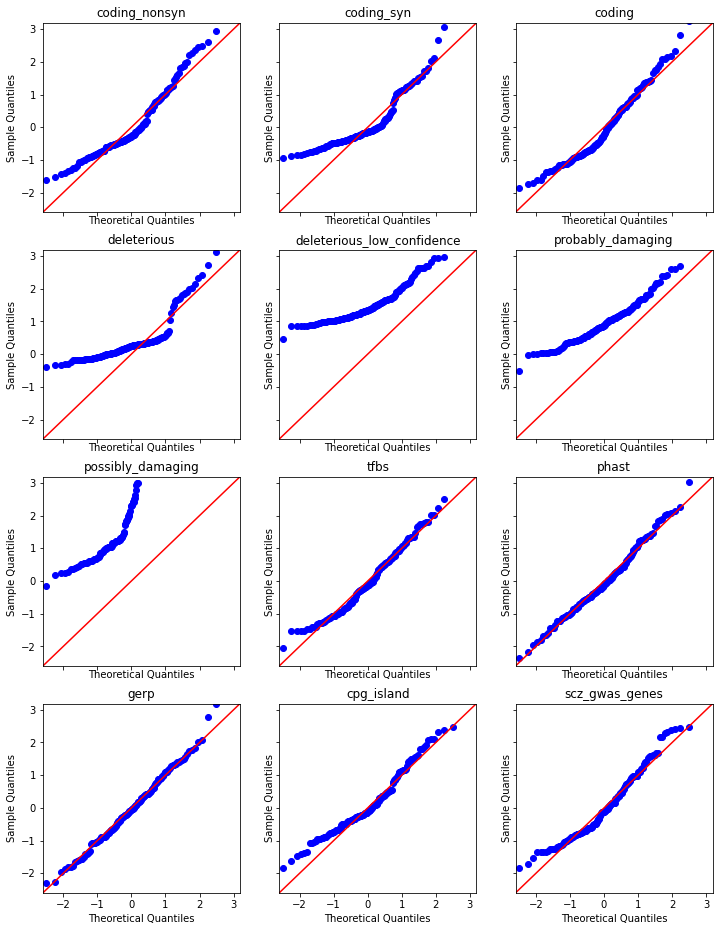

In [32]:
fig, ax = icm.QQ_rstar_residual(poiss)

## Logistic regression (binomial error model)

This is based on the proportion type response introduced above.

### Full model

In [33]:
formula = 'Dx + DP + AF + ageOfDeath + Dataset'
X = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')

Response can be given as either:
1. counts of both success and failure
1. proportions

In [34]:
success_failure = endog_binomial('scz_gwas_genes', fitdata, False)
proportion = endog_binomial('scz_gwas_genes', fitdata, proportion=True)
pd.concat([success_failure, proportion, fitdata['ncalls']], axis=1).rename({0: 'proportion'}, axis=1)

,scz_gwas_genes,NOT_scz_gwas_genes,proportion,ncalls
Individual ID,,,,
AN02255,1,20,0.047619,21
AN05983,2,183,0.010811,185
AN06365,0,27,0.000000,27
AN09412,1,29,0.033333,30
AN12434,1,46,0.021277,47
...,...,...,...,...
UMB5878,0,30,0.000000,30
UMB5939,1,23,0.041667,24
UMB797,0,42,0.000000,42


When using proportion type response then the total number of calls `fitdata['ncalls']` must be passed as `var_weights` to `GLM`.  Note that the two fits result in the same parameter estimates.

In [35]:
# Method: response is a success failure pair
mod = sm.GLM(endog=success_failure, exog=X, family=sm.families.Binomial()).fit()
# Method 2: response is a proportion; var_weights must be specified
mod_p = sm.GLM(endog=proportion, exog=X, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit()
# Check if parameter estimates are identical
all(mod.params == mod_p.params)

True

In [36]:
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
======================================================================================
Model:              GLM                                      AIC:            361.1533 
Link Function:      logit                                    BIC:            -584.7267
Dependent Variable: ['scz_gwas_genes', 'NOT_scz_gwas_genes'] Log-Likelihood: -173.58  
Date:               2021-02-19 14:30                         LL-Null:        -181.83  
No. Observations:   158                                      Deviance:       179.73   
Df Model:           6                                        Pearson chi2:   186.     
Df Residuals:       151                                      Scale:          1.0000   
Method:             IRLS                                                              
------------------------------------------------------------------------------------------
                        Coef.      Std.Err.        z        P>|z|       [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -5.6634       0.7503     -7.5485     0.0000     -7.1340     -4.1929
Dx[T.SCZ]               0.9132       0.3435      2.6585     0.0078      0.2399      1.5864
Dx[T.ASD]               0.3394       0.3548      0.9566     0.3388     -0.3560      1.0349
Dataset[T.Walsh]        0.6805       0.5238      1.2993     0.1939     -0.3461      1.7070
DP                      0.0017       0.0013      1.3011     0.1932     -0.0009      0.0042
AF                     -0.0927       4.2109     -0.0220     0.9824     -8.3458      8.1604
ageOfDeath              0.0110       0.0058      1.9096     0.0562     -0.0003      0.0224
======================================================================================

"""

In [37]:
formula = '1 + Dx + ageOfDeath'
mod = binom_modsel[formula]
mod.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
======================================================================================
Model:              GLM                                      AIC:            358.2820 
Link Function:      logit                                    BIC:            -596.7858
Dependent Variable: ['scz_gwas_genes', 'NOT_scz_gwas_genes'] Log-Likelihood: -175.14  
Date:               2021-02-19 14:30                         LL-Null:        -181.83  
No. Observations:   158                                      Deviance:       182.85   
Df Model:           3                                        Pearson chi2:   184.     
Df Residuals:       154                                      Scale:          1.0000   
Method:             IRLS                                                              
-------------------------------------------------------------------------------------------
                   Coef.       Std.Err.         z          P>|z|        [0.025       0.975]
-------------------------------------------------------------------------------------------
Intercept         -4.7688        0.3501      -13.6203      0.0000      -5.4550      -4.0825
Dx[T.SCZ]          0.6709        0.2698        2.4865      0.0129       0.1421       1.1998
Dx[T.ASD]          0.5977        0.3023        1.9773      0.0480       0.0052       1.1901
ageOfDeath         0.0073        0.0051        1.4316      0.1523      -0.0027       0.0174
======================================================================================

"""

## Other features
Here we fit a model without `ageOfDeath`; thus the only explanatory variable is `Dx`.

In [38]:
formula = '1 + Dx'
X = patsy.dmatrix(formula, data=fitdata, return_type='dataframe')
endognames = ['coding_nonsyn', 'coding_syn', 'coding', 'deleterious', 'deleterious_low_confidence', 'probably_damaging', 'possibly_damaging', 'tfbs', 'phast', 'gerp', 'cpg_island', 'scz_gwas_genes']
proportions = {endog: endog_binomial(endog, fitdata, proportion=True) for endog in endognames}
binoms = {endog: sm.GLM(endog=proportions[endog], exog=X, family=sm.families.Binomial(), var_weights=fitdata['ncalls']).fit() for endog in proportions.keys()}

['named-figure/SCZ-significance.png', 'named-figure/SCZ-significance.pdf']

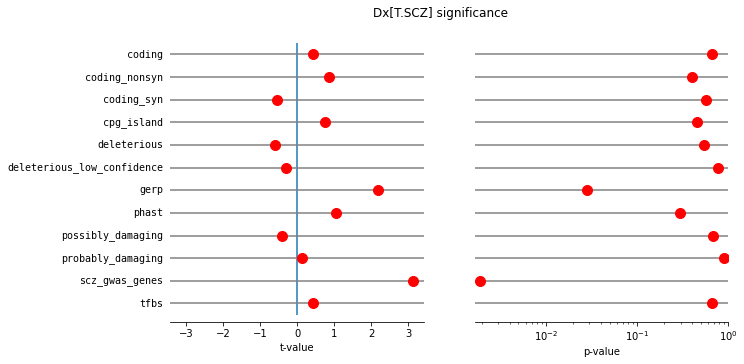

In [39]:
%matplotlib inline
fig, ax = icm.my_dotplot('Dx[T.SCZ]', binoms)
attila_utils.savefig(fig, 'SCZ-significance')

['named-figure/ASD-significance.png', 'named-figure/ASD-significance.pdf']

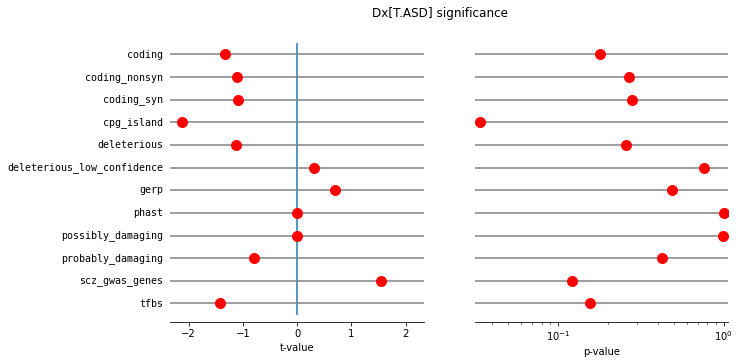

In [40]:
fig, ax = icm.my_dotplot('Dx[T.ASD]', binoms)
attila_utils.savefig(fig, 'ASD-significance')

## Model checking

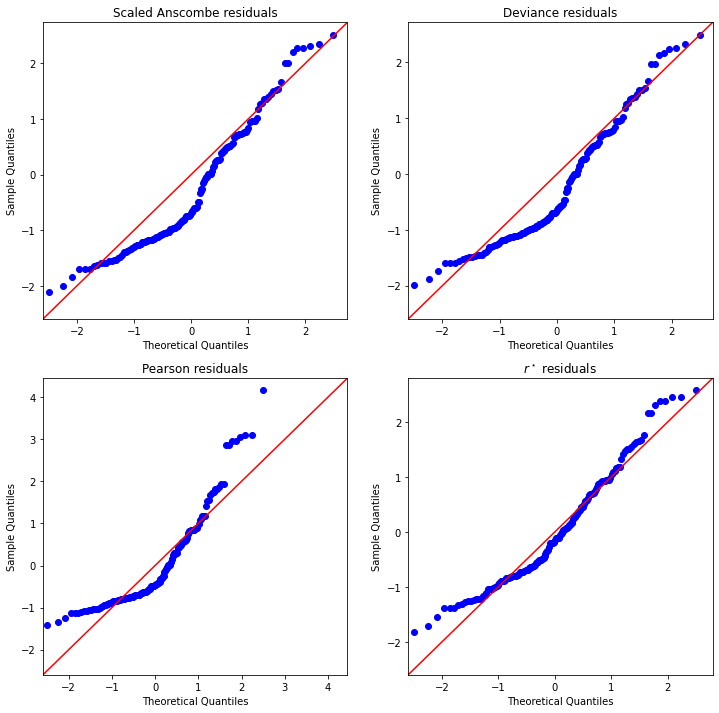

In [41]:
fig, ax = icm.QQ_four_residual_types(binoms['scz_gwas_genes'])

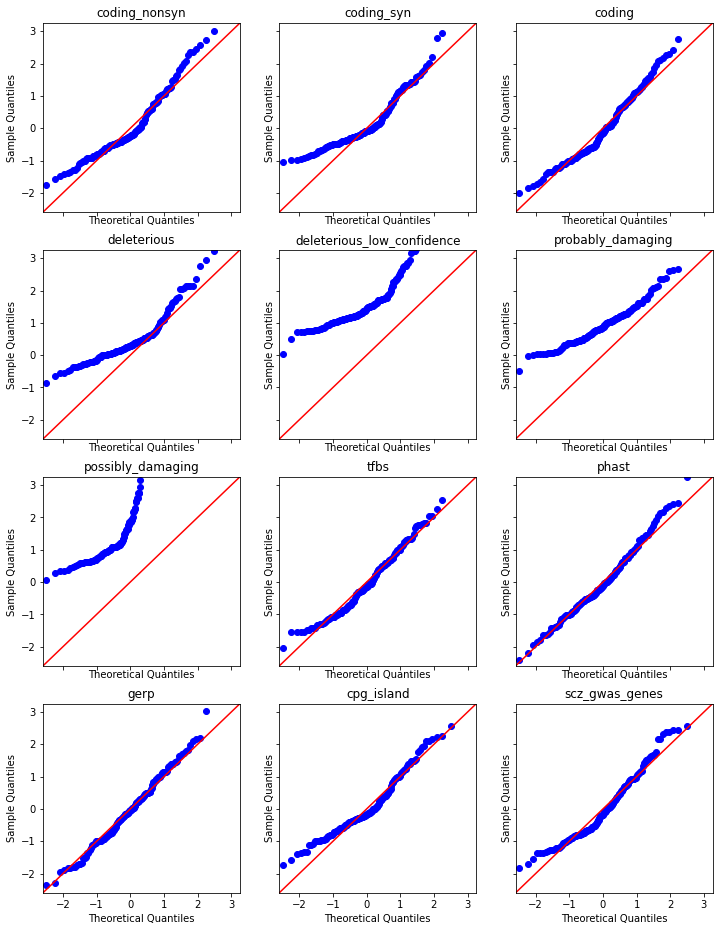

In [42]:
fig, ax = icm.QQ_rstar_residual(binoms)

In [43]:
%connect_info

{
  "shell_port": 57861,
  "iopub_port": 38175,
  "stdin_port": 53327,
  "control_port": 49669,
  "hb_port": 60747,
  "ip": "127.0.0.1",
  "key": "33642035-f8946e4e73671b1c28dcdbb6",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-28172537-affb-4e03-bf12-6f346f608490.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
